In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import torch
from kan import KAN
import matplotlib.pyplot as plt
import numpy as np

### Carregando e dividindo os dados

In [2]:
df_train = pd.read_csv('data/train_processed.csv')
df_test = pd.read_csv('data/test_processed.csv')

X_train = df_train.drop(columns=['satisfaction_satisfied']).values
y_train = df_train['satisfaction_satisfied'].values
X_test = df_test.drop(columns=['satisfaction_satisfied']).values
y_test = df_test['satisfaction_satisfied'].values

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

### Convertendo para tensores

In [3]:
train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train, dtype=torch.long)
test_input = torch.tensor(X_test, dtype=torch.float32)
test_label = torch.tensor(y_test, dtype=torch.long)

dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

### Funções de treinamento

In [51]:
def train_and_evaluate_model(width, grid, k, steps, loss_fn, opt):
    model = KAN(width=width, grid=grid, k=k)

    # Funções de avaliação
    def train_acc():
        return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

    def test_acc():
        return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())
    
    results = model.fit(dataset, opt=opt, steps=steps, metrics=(train_acc, test_acc), loss_fn=loss_fn)

    for key in results:
        results[key] = np.array(results[key])

    return results, model

In [49]:
def plot_evolution(train_accuracy, test_accuracy, train_loss, test_loss):
    # Plot for first and second arrays
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracy, 'g', label='Train')  # Green color
    plt.plot(test_accuracy, 'r', label='Test')  # Red color
    plt.scatter(len(train_accuracy) - 1, train_accuracy[-1], color='g')  # Point for the last element of train_accuracy
    plt.text(len(train_accuracy) - 1, train_accuracy[-1], f'{train_accuracy[-1]*100:.2f}', fontsize=12, ha='right')
    plt.scatter(len(test_accuracy) - 1, test_accuracy[-1], color='r')  # Point for the last element of test_accuracy
    plt.text(len(test_accuracy) - 1, test_accuracy[-1], f'{test_accuracy[-1]*100:.2f}', fontsize=12, ha='right')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot for third and fourth arrays
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, 'g', label='Train')  # Green color
    plt.plot(test_loss, 'r', label='Test')  # Red color
    plt.scatter(len(train_loss) - 1, train_loss[-1], color='g')  # Point for the last element of train_loss
    plt.text(len(train_loss) - 1, train_loss[-1], f'{train_loss[-1]:.4f}', fontsize=12, ha='right')
    plt.scatter(len(test_loss) - 1, test_loss[-1], color='r')  # Point for the last element of test_loss
    plt.text(len(test_loss) - 1, test_loss[-1], f'{test_loss[-1]:.4f}', fontsize=12, ha='right')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [53]:
def grid_search(param_grid):
    best_params = None
    best_accuracy = 0
    best_model = None
    best_results = None

    # Iterar sobre todas as combinações de hiperparâmetros
    for width in param_grid['width']:
        for grid in param_grid['grid']:
            for k in param_grid['k']:
                for steps in param_grid['steps']:
                    for opt in param_grid['opt']:
                        results, model = train_and_evaluate_model([X_train.shape[1], 2], 3, 3, 10, loss_fn, opt)
                        train_acc = results['train_acc'][-1]
                        test_acc = results['test_acc'][-1]
                        print(f"Width: {width}, Grid: {grid}, K: {k}, Steps: {steps}, Optimizer: {opt} Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
                        
                        if test_acc > best_accuracy:
                            best_accuracy = test_acc
                            best_results = results
                            best_params = {'width': width, 'grid': grid, 'k': k, 'steps': steps, 'opt': opt}
                            best_model = model
    
    return best_params, best_results, best_model

In [60]:
loss_fn = torch.nn.CrossEntropyLoss()
param_grid = {
    'width': [[X_train.shape[1], 2]],
    'grid': [2],
    'k': [2],
    'steps': [10, 20, 30, 40],
    'opt': ['Adam', 'SGD', 'LBFGS']
}

description:   0%|                                                           | 0/10 [00:00<?, ?it/s]

train loss: 2.05e+00 | test loss: 1.76e+00 | reg: 6.51e+01 : 100%|██| 10/10 [00:15<00:00,  1.54s/it]


Width: [25, 2], Grid: 2, K: 2, Steps: 10, Optimizer: Adam Train Acc: 0.8367, Test Acc: 0.8251


train loss: 2.05e+00 | test loss: 9.16e-01 | reg: 6.51e+01 : 100%|██| 10/10 [00:08<00:00,  1.20it/s]


Width: [25, 2], Grid: 2, K: 2, Steps: 10, Optimizer: SGD Train Acc: 0.5568, Test Acc: 0.5527


train loss: 4.22e-01 | test loss: 4.34e-01 | reg: 2.28e+01 : 100%|██| 10/10 [02:19<00:00, 13.91s/it]


Width: [25, 2], Grid: 2, K: 2, Steps: 10, Optimizer: LBFGS Train Acc: 0.9342, Test Acc: 0.9318


train loss: 2.05e+00 | test loss: 1.76e+00 | reg: 6.51e+01 : 100%|██| 10/10 [00:15<00:00,  1.50s/it]


Width: [25, 2], Grid: 2, K: 2, Steps: 20, Optimizer: Adam Train Acc: 0.8367, Test Acc: 0.8251


train loss: 2.05e+00 | test loss: 9.16e-01 | reg: 6.51e+01 : 100%|██| 10/10 [00:08<00:00,  1.11it/s]


Width: [25, 2], Grid: 2, K: 2, Steps: 20, Optimizer: SGD Train Acc: 0.5568, Test Acc: 0.5527


train loss: 4.22e-01 | test loss: 4.34e-01 | reg: 2.28e+01 : 100%|██| 10/10 [02:10<00:00, 13.10s/it]


Width: [25, 2], Grid: 2, K: 2, Steps: 20, Optimizer: LBFGS Train Acc: 0.9342, Test Acc: 0.9318


train loss: 2.05e+00 | test loss: 1.76e+00 | reg: 6.51e+01 : 100%|██| 10/10 [00:13<00:00,  1.39s/it]


Width: [25, 2], Grid: 2, K: 2, Steps: 30, Optimizer: Adam Train Acc: 0.8367, Test Acc: 0.8251


train loss: 2.05e+00 | test loss: 9.16e-01 | reg: 6.51e+01 : 100%|██| 10/10 [00:08<00:00,  1.17it/s]


Width: [25, 2], Grid: 2, K: 2, Steps: 30, Optimizer: SGD Train Acc: 0.5568, Test Acc: 0.5527


train loss: 4.22e-01 | test loss: 4.34e-01 | reg: 2.28e+01 : 100%|██| 10/10 [02:11<00:00, 13.10s/it]


Width: [25, 2], Grid: 2, K: 2, Steps: 30, Optimizer: LBFGS Train Acc: 0.9342, Test Acc: 0.9318


train loss: 2.05e+00 | test loss: 1.76e+00 | reg: 6.51e+01 : 100%|██| 10/10 [00:13<00:00,  1.40s/it]


Width: [25, 2], Grid: 2, K: 2, Steps: 40, Optimizer: Adam Train Acc: 0.8367, Test Acc: 0.8251


train loss: 2.05e+00 | test loss: 9.16e-01 | reg: 6.51e+01 : 100%|██| 10/10 [00:08<00:00,  1.18it/s]


Width: [25, 2], Grid: 2, K: 2, Steps: 40, Optimizer: SGD Train Acc: 0.5568, Test Acc: 0.5527


train loss: 4.22e-01 | test loss: 4.34e-01 | reg: 2.28e+01 : 100%|██| 10/10 [02:12<00:00, 13.27s/it]

Width: [25, 2], Grid: 2, K: 2, Steps: 40, Optimizer: LBFGS Train Acc: 0.9342, Test Acc: 0.9318


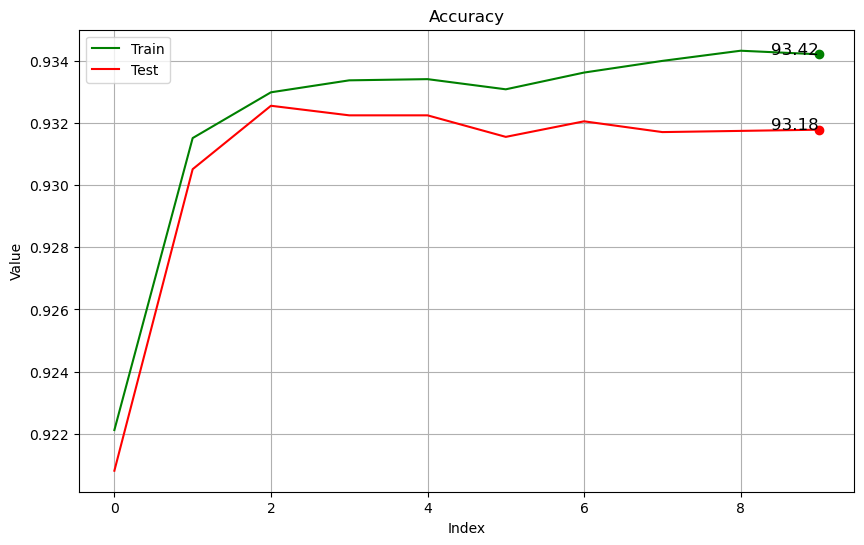

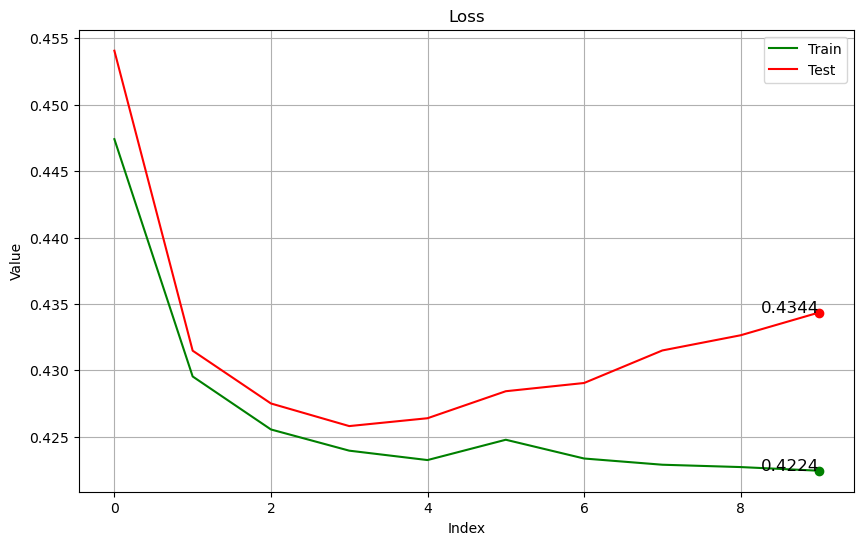

In [61]:
best_params, results, model = grid_search(param_grid)
plot_evolution(results['train_acc'], results['test_acc'], results['train_loss'], results['test_loss'])

In [62]:
best_params

{'width': [25, 2], 'grid': 2, 'k': 2, 'steps': 10, 'opt': 'LBFGS'}